In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
from tensorflow.python.keras.models import load_model

In [6]:
cal_fire_s2_stacked_df = pd.read_csv('../Data/Processed/WildFire_S2Cells_stacked.csv')
cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'].shape

(93, 16)

In [7]:
cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'].head()

,FIRE_CUSTOM_ID,S2_Cells_ID,FZ_grp,AGENCY,UNIT_ID,CAUSE,GIS_ACRES,C_METHOD,OBJECTIVE,Shape_Length,Shape_Area,YEAR,ALARM_DATE_DT_DT,CONT_DATE_DT_DT,FIRE_DUR,ALARM_DATE_MONTH
1196,CAMP_2018_11_08_0,808334,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1197,CAMP_2018_11_08_0,809ccc,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1198,CAMP_2018_11_08_0,8082d4,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1199,CAMP_2018_11_08_0,80832c,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11
1200,CAMP_2018_11_08_0,809cc4,low,CDF,BTU,11.0,153335.5625,1.0,1.0,311935.278756,6.205270e+08,2018,2018-11-08,2018-11-26,19.0,11


In [8]:
camp_ids = cal_fire_s2_stacked_df[cal_fire_s2_stacked_df.FIRE_CUSTOM_ID=='CAMP_2018_11_08_0'][['S2_Cells_ID', 'ALARM_DATE_DT_DT', 'FZ_grp']]
camp_ids.columns = ['s2_cell_id', 'measure_date', 'FZ_grp']
camp_ids.head()

,s2_cell_id,measure_date,FZ_grp
1196,808334,2018-11-08,low
1197,809ccc,2018-11-08,low
1198,8082d4,2018-11-08,low
1199,80832c,2018-11-08,low
1200,809cc4,2018-11-08,low


In [9]:
camp_ids.FZ_grp.value_counts()

high    65
med     20
low      8
Name: FZ_grp, dtype: int64

In [10]:
def split_train_test(data, features):
    indexer = data[['s2_cell_id','measure_date']].copy()
    train = data[data.measure_date < '2018-01-01'].copy()
    test = data[data.measure_date >= '2018-01-01'].copy()
    
    y_train = train.wf_wildfire.copy().values
    y_test = test.wf_wildfire.copy().values    
    
    train = train[features]
    test = test[features]    
    
    test_ids = data[data.measure_date >= '2018-01-01'][['s2_cell_id', 'measure_date']]
    
    return train, test, y_train, y_test, test_ids

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [11]:
scaler = MinMaxScaler()

In [19]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

wf_features = [
    'wf_count_1yr_ago',
    'wf_count_2yr_ago',
    'wf_count_3yr_ago',
    'wf_count_4yr_ago',
    'wf_count_5yr_ago'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
#  'sat_faparval_median',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
#  'sat_faparmask_median',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
#  'wea_precip_accum_max',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
#  'wea_precip_accum_max_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
#  'wea_precip_accum_max_l1',
 'relative_humidity_mean_l1'
]

new_features = [
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
 'wea_air_temp_mean_ma30',
#  'wea_precip_accum_max_ma30',
 'relative_humidity_mean_ma30'
]

In [21]:
feature_cols = wea_features + tl_features + sat_features + ['fuel_percent'] + new_features

In [17]:
scaler = pickle.load(open('./Models/scaler_10pct_noprecip_ext', 'rb'))

In [15]:
test_df = pd.read_csv('./consolidated_4_2018.csv')
test_df.shape

(3884695, 40)

In [22]:
gc.collect()
cuts = list(range(0, test_df.shape[0], test_df.shape[0]//10+1))
cuts[-1] = test_df.shape[0]+1
test_sc = np.empty([0,len(feature_cols)])
for i in range(len(cuts[:-1])):
    print("Cut: {}".format(cuts[i]))
    temp = test_df[cuts[i]:cuts[i+1]][feature_cols]  
    temp = scaler.transform(temp)
    test_sc = np.append(test_sc, temp, axis=0)
test_sc.shape

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760


(3884695, 33)

In [23]:
y_test = test_df.wf_wildfire.copy().values    
test_ids = test_df[['s2_cell_id', 'measure_date']]

In [24]:
model_mlp_adam_noprecip_cwEQ_ext = load_model('./Models/mlp_adam_noprecip_cwEQ_ext.h5')
mlp_adam_noprecip_cwEQ_ext_probs = model_mlp_adam_noprecip_cwEQ_ext.predict(test_sc)
bin_prob(mlp_adam_noprecip_cwEQ_ext_probs[:,0], y_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Prob    Actual               
         mean      mean    sum   count
Bin                                   
1    0.050709  0.000021    5.0  233972
2    0.151029  0.000082   20.0  244236
3    0.253235  0.000180   56.0  310634
4    0.353762  0.000190   92.0  484786
5    0.452252  0.000301  215.0  714675
6    0.549803  0.000375  297.0  791379
7    0.647147  0.000500  338.0  675705
8    0.741040  0.000497  186.0  374604
9    0.823566  0.000611   33.0   54037
10   0.942598  0.000000    0.0     391
11   1.000000  0.000000    0.0     276

Confusion matrix, without normalization
[[1987916 1895537]
 [    388     854]]
              precision    recall  f1-score   support

         nwf       1.00      0.51      0.68   3883453
          wf       0.00      0.69      0.00      1242

   micro avg       0.51      0.51      0.51   3884695
   macro avg       0.50      0.60      0.34   3884695
weighted avg       1.00      0.51      0.68   3884695



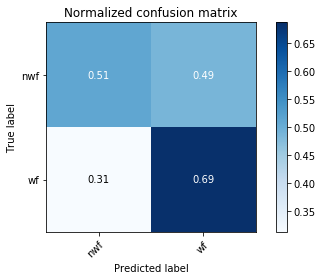

In [25]:
mlp_adam_noprecip_cwEQ_ext_preds = mlp_adam_noprecip_cwEQ_ext_probs[:,0]>0.5
plot_confusion_matrix(y_test, mlp_adam_noprecip_cwEQ_ext_preds, ['nwf', 'wf'], normalize=True)

In [39]:
test_sc_df = pd.DataFrame(test_sc)
test_sc_df.columns = feature_cols
test_sc_df.shape

(3884695, 33)

In [41]:
features_df = test_sc_df.groupby(mlp_adam_noprecip_cwEQ_ext_preds).mean().T
features_df.columns = ['nwf', 'wf']
features_df['pct_diff'] = (features_df.wf / features_df.nwf) - 1
features_df.sort_values('pct_diff')

,nwf,wf,pct_diff
sat_faparmask_min,0.000900,0.000007,-0.992381
sat_faparmask_mean,0.062784,0.017306,-0.724365
tl_kv_sort_sum,0.025769,0.007342,-0.715088
tl_object_id,0.014182,0.005376,-0.620921
sat_faparval_count,0.164860,0.063687,-0.613690
sat_faparval_size,0.164860,0.063687,-0.613690
sat_faparmask_size,0.164860,0.063687,-0.613690
sat_faparmask_std,0.162324,0.081144,-0.500110
wea_wind_speed_min,0.006555,0.003383,-0.483865
sat_faparmask_max,0.359412,0.194188,-0.459706


In [110]:
with open('./Models/mlp_adam_noprecip_cwEQ_ext_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+','+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_noprecip_cwEQ_ext_probs[i,0])+'\n')